## <center>Processing Images</center>

In this notebook, we will learn the steps of image preprocessing that are necessary for a deep agent to work properly on images. <br />
As already mentioned in the last lecture, when dealing with image data, we often need to store multiple sequential frames in order to feed all available data to the agent. <br />
It is not possible to decide whether a ball moves to the left or to the right given only a single image. <br />
keras-rl provides a class called **Processor** which is used to process the image data before it gets fed into the backbone network

Let us first start by importing the necessary libraries

In [1]:
from PIL import Image  # To handle images
import matplotlib.pyplot as plt  # For plotting
import numpy as np
import gym
import time

from rl.core import Processor  # To process the image within the keras-rl training routine
from rl.memory import SequentialMemory  # To store the sequential frames


Let us first create an image based environment, namely the famous game called **Breakout**

In [2]:
env = gym.make("Breakout-v0")
env.reset()  
for _ in range(5):
    env.render(mode="human") 
    action = env.action_space.sample()  
    env.step(action)  
    time.sleep(0.5)
env.close()  

### Image storage

We need to decide how many sequential frames are necessary to capture all information. This is also called window_length, which we need to pass to the **SequentialMemory**

In [3]:
WINDOW_LENGTH = 3

What replay memory effectively does, is that it appends WINDOW_LENGTH sequential frames to a list and then appends this whole list to the memory.
Thus a single element from our SequentialMemory contains WINDOW_LENGTH (consecutive images) <br />


In [4]:
from collections import deque

In [5]:
env = gym.make("Breakout-v0")
env.reset()

memory = []  # Sequential buffer in which the images are stored

# Temporary storage to capture sequential frames which can store a max of WINDOW_LENGTH images
deque_memory = deque(maxlen=WINDOW_LENGTH)

for i in range(10):
    if i == 0:
        action = 1
    else:
        action = env.action_space.sample()
    
    observation, *_ = env.step(action) 
    
    # We have to wait until the deque is full (so it contains exactly WINDOW_LENGTH images)
    if len(deque_memory) == WINDOW_LENGTH: 
        # If the deque is full we know that it contains WINDOW_LENGTH frames and we append those frames
        # to our actual memory
        memory.append(list(deque_memory))
    
    # Update the deque
    deque_memory.append(observation)
env.close()

print(f"Total length: {len(memory)*len(deque_memory)}, individual length: {len(memory)}")

Total length: 21, individual length: 7


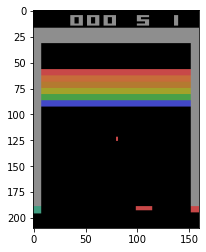

In [6]:
plt.imshow(memory[0][0])

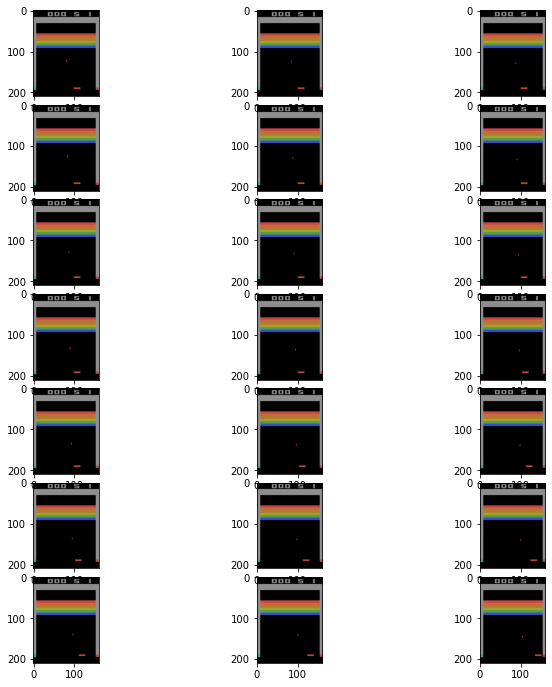

In [7]:
fig, axs = plt.subplots(7,3, figsize=(12, 12))

for i in range(7):
    for j in range(3):
        axs[i,j].imshow(memory[i][j])
fig.subplots_adjust(wspace=0, hspace=0.1)

Of course we do not have to do this by ourselves as keras-rl does it automatically if WINDOW_LENGTH is larger than 1

In [8]:
# does the same thing in a much more optimized way
memory = SequentialMemory(limit=1000, window_length=WINDOW_LENGTH)

### Processing the image

Besides that we need to decide how large our images should be. Larger images might contain more information but also increase the training time. Let us use an image size of $84\times84$

In [9]:
IMG_SHAPE = (84, 84)

Now we can create image processing class, which inherits the **Processor** provided by keras-rl (https://github.com/keras-rl/keras-rl/blob/master/rl/core.py#L515)

Each processor can define the following methods:
1. *process_step(observation, reward, done, info)* ("Processes an entire step by applying the processor to the observation, reward, and info arguments". Used during inference)
2. *process_observation(observation)* ("Processes the observation as obtained from the environment for use in an agent and returns it")
3. *process_reward(reward)* ("Processes the reward as obtained from the environment for use in an agent and returns it")
4. *process_info(info)* ("Processes the info as obtained from the environment for use in an agent and returns it)
5. *process_action(action)* ("Processes an action predicted by an agent but before execution in an environment")
6. *process_state_batch(batch)* ("Processes an entire batch of states and returns it". Used for training)

The overall use of the processor is to act as a "translator" which translates the observation provided by gym into something our network can handle

Let's define our first processor, called **BreakOutProcessor**
As we do not train in this notebook, we only overwrite the *process_observation* function. <br />
This function has to perform two operations:
1. Resize the image to our desired shape
2. Convert it to grayscale (as the colored images do not yield any more information in this case)
We will use PIL to perform those tasks

In [10]:
class BreakOutProcessor(Processor):
    def process_observation(self, observation):
        # First convert the numpy array to a PIL Image
        img = Image.fromarray(observation)
        # Then resize the image
        img = img.resize(IMG_SHAPE)
        # And convert it to grayscale  (The L stands for luminance)
        img = img.convert("L")
        # Finally we convert the image back to a numpy array and return it
        img = np.array(img)
        return img

We can now try the processor

In [11]:
sample_images = []
breakout_proc = BreakOutProcessor()
env.reset()
for _ in range(200):
    action = env.action_space.sample() 
    observation, *info = env.step(action)  # and perform it on the environment to get the next state
    processed_observation = breakout_proc.process_observation(observation)
    sample_images.append(processed_observation)

In [12]:
print(f"The shape of the original observation is {observation.shape} " \
        f"and the shape of the processed observation is {processed_observation.shape}")

The shape of the original observation is (210, 160, 3) and the shape of the processed observation is (84, 84)


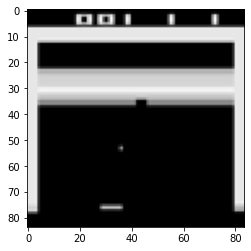

In [13]:
plt.figure()
plt.imshow(sample_images[-1], cmap="gray")